<a href="https://colab.research.google.com/github/Sameer55555/Practice/blob/master/MNIST_building_blocks_of_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MNIST Neural Network from Scratch**

Fully Connected Layer

In [0]:
import numpy as np

In [0]:
class Linear():
  def __init__(self, in_size, out_size):
    self.W = np.random.randn(in_size, out_size)*0.01
    self.b = np.zeros((1, out_size)) 
    self.params = [self.W, self.b]
    self.gradW = None
    self.gradB = None
    self.gradinput = None

  def forward(self, X):
    self.X = X
    self.output = np.dot(X, self.W) + self.b
    return self.output
  
  def backward(self, nextgrad):
    self.gradW = np.dot(self.X.T, nextgrad)
    self.gradB = np.sum(nextgrad, axis = 0)
    self.gradinput = np.dot(nextgrad, self.W.T)
    return self.gradinput, [self.gradW, self.gradB] 

Rectified Linear Activation Layer

In [0]:
class ReLU():
  def __init__(self):
    self.params = []
    self.gradinput = None

  def forward(self, X):
    self.output = np.maximum(X, 0)
    return self.output
  
  def backward(self, nextgrad):
    self.gradinput = nextgrad.copy()
    self.gradinput[self.output <= 0] = 0
    return self.gradinput, [] 

Defining Softmax Function

In [0]:
def softmax(x):
  exp_x =  np.exp(x - np.max(x, axis = 1, keepdims= True))
  return exp_x / np.sum(exp_x, axis = 1, keepdims= True)


Defining CrossEntropy

In [0]:
class CrossEntropy():
  def forward(self, X, y):
    self.m = y.shape[0]
    self.p = softmax(X)
    cross_entropy = -np.log(self.p[range(self.m), y]+1e-16)
    loss = np.sum(cross_entropy) / self.m
    return loss
  
  def backward(self, X, y):
    y_idx = y.argmax()
    grad = softmax(X)
    grad[range(self.m), y] -= 1
    grad /= self.m
    return grad 

Loading MNIST Datasets

In [100]:
from keras.datasets import mnist
from keras.utils import np_utils

(train_features, train_targets), (test_features, test_targets) = mnist.load_data()

train_features = train_features.reshape(60000, 784)
print(train_features.shape)
test_features = test_features.reshape(10000, 784)
print(test_features.shape)

train_features = train_features / 255.0
test_features = test_features / 255.0

print(train_targets.shape)
print(test_targets.shape)

X_train = train_features
y_train = train_targets

X_val = test_features
y_val = test_targets

(60000, 784)
(10000, 784)
(60000,)
(10000,)


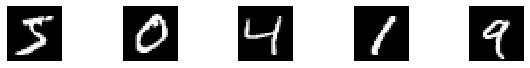

label for each of the above image: [5 0 4 1 9]


In [101]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize = (10,1))
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(X_train[i].reshape(28,28), cmap="gray")
  plt.axis('off')
plt.show()
print('label for each of the above image: %s' %(y_train[0:5]))

Neural Network Class


In [0]:
class NN():
  def __init__(self, lossfunc=CrossEntropy(), mode = 'train'):
    self.params = []
    self.layers = []
    self.loss_func = lossfunc
    self.grads = []
    self.mode = mode

  def add_layer(self, layer):
    self.layers.append(layer)
    self.params.append(layer.params)
  
  def forward(self, X):
    for layer in self.layers:
      X = layer.forward(X)
    return X
  
  def backward(self, nextgrad):
    self.clear_grad_param()
    for layer in reversed(self.layers):
      nextgrad, grad = layer.backward(nextgrad)
      self.grads.append(grad)
    return self.grads
  
  def train_step(self, X, y):
    out = self.forward(X)
    loss = self.loss_func.forward(out,y)
    nextgrad = self.loss_func.backward(out,y)
    grads = self.backward(nextgrad)
    return loss, grads

  def predict(self, X):
    X = self.forward(X)
    return np.argmax(X, axis=1)
  
  def predict_scores(self, X):
    X = self.forward(X)
    return X

  def clear_grad_param(self):
    self.grads = []

Defining the Update Function

In [0]:
def update_params(velocity, params, grads, learning_rate=0.01, mu=0.9):
  for v, p, g, in zip(velocity, params, reversed(grads)):
    for i in range(len(g)):
      v[i] = mu*v[i] + learning_rate*g[i]
      p[i] -= v[i]

Defining a Function for Minibatches

In [0]:
def minibatch(X, y, minibatch_size):
  n = X.shape[0]
  minibatches = []
  permutation = np.random.permutation(X.shape[0])
  X = X[permutation]
  y = y[permutation]

  for i in range(0, n, minibatch_size):
    X_batch = X[i:i + minibatch_size, :]
    y_batch = y[i:i + minibatch_size, ]
    minibatches.append((X_batch, y_batch))

  return minibatches

Training Loop

In [0]:
def train(net, X_train, y_train, minibatch_size, epoch, learning_rate, mu=0.9, X_val=None, y_val=None):
  val_loss_epoch = []
  minibatches = minibatch(X_train, y_train, minibatch_size)
  minibatches_val = minibatch(X_val, y_val, minibatch_size)

  for i in range(epoch):
    loss_batch = []
    val_loss_batch = []
    velocity = []
    for param_layer in net.params:
      p = [np.zeros_like(param) for param in list(param_layer)]
      velocity.append(p)
    
    #iterate over minibatches
    for X_mini, y_mini in minibatches:
      loss, grads = net.train_step(X_mini, y_mini)
      loss_batch.append(loss)
      update_params(velocity, net.params, grads, learning_rate=0.01, mu=0.9)

    for X_mini, y_mini in minibatches_val:
      val_loss, _ = net.train_step(X_mini, y_mini)
      val_loss_batch.append(val_loss)

    #accuracy of model at end of epoch after all mini batch updates
    m_train = X_train.shape[0]
    m_val = X_val.shape[0]
    y_train_pred = np.array([], dtype="int64")
    y_val_pred = np.array([], dtype="int64")
    y_train1 = []
    y_vall = []
    for i in range(0, m_train, minibatch_size):
      X_tr = X_train[i:i + minibatch_size, :]
      y_tr = y_train[i:i + minibatch_size,]
      y_train1 = np.append(y_train1, y_tr)
      y_train_pred = np.append(y_train_pred, net.predict(X_tr))

    for i in range(0, m_val, minibatch_size):
      X_va = X_val[i:i + minibatch_size, :]
      y_va = y_val[i:i + minibatch_size,]
      y_val1 = np.append(y_vall, y_va)
      y_val_pred = np.append(y_val_pred, net.predict(X_va))

    train_acc = check_accuracy(y_train1, y_train_pred)
    val_acc = check_accuracy(y_vall, y_val_pred)
    
    mean_train_loss = sum(loss_batch)/float(len(loss_batch))
    mean_val_loss = sum(val_loss_batch) /float(len(val_loss_batch))

    val_loss_epoch.append(mean_val_loss)
    print("Loss = (0) | Traiining Accuracy = {1}| Val Loss = {2} | Val Accuracy = {3}".format(mean_train_loss, train_acc, mean_val_loss, val_acc))
  return net

Checking the Accuracy of the model

In [0]:
def check_accuracy(y_true, y_pred):
  return np.mean(y_pred == y_true)

Invoking all that we have created till now

In [107]:
from random import shuffle

## input size
input_dim = X_train.shape[1]

## hyperparameters
iterations = 10
learning_rate = 1e4
hidden_nodes = 32
output_nodes = 10

## define neural net
nn = NN()
nn.add_layer(Linear(input_dim, hidden_nodes))
nn.add_layer(ReLU())
nn.add_layer(Linear(hidden_nodes, output_nodes))

nn = train(nn, X_train , y_train, minibatch_size=200, epoch=10, \
           learning_rate=learning_rate, X_val=X_val, y_val=y_val)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


Loss = (0) | Traiining Accuracy = 0.8690333333333333| Val Loss = 0.45260781704449743 | Val Accuracy = 0.0
Loss = (0) | Traiining Accuracy = 0.9004| Val Loss = 0.3346811198092868 | Val Accuracy = 0.0
Loss = (0) | Traiining Accuracy = 0.9123| Val Loss = 0.29652040868596047 | Val Accuracy = 0.0
Loss = (0) | Traiining Accuracy = 0.9191333333333334| Val Loss = 0.2727430984902421 | Val Accuracy = 0.0
Loss = (0) | Traiining Accuracy = 0.92485| Val Loss = 0.25464925013063433 | Val Accuracy = 0.0
Loss = (0) | Traiining Accuracy = 0.92945| Val Loss = 0.23997319900001413 | Val Accuracy = 0.0
Loss = (0) | Traiining Accuracy = 0.9343833333333333| Val Loss = 0.22682950016596007 | Val Accuracy = 0.0
Loss = (0) | Traiining Accuracy = 0.9377666666666666| Val Loss = 0.21481254305035002 | Val Accuracy = 0.0
Loss = (0) | Traiining Accuracy = 0.9408333333333333| Val Loss = 0.20398730999262932 | Val Accuracy = 0.0
Loss = (0) | Traiining Accuracy = 0.94385| Val Loss = 0.19434978906359826 | Val Accuracy = 0.0

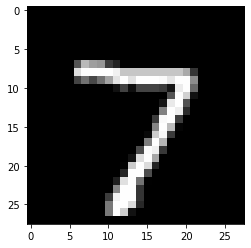

In [108]:
 plt.imshow(X_val[0].reshape(28,28), cmap='gray')

In [0]:
# Predict Scores for each class
prediction = nn.predict_scores(X_val[0])[0]

In [110]:
print("Scores")
print(prediction)

Scores
[ 1.15583255 -8.26740847  2.30774546  4.14921257 -3.31610057  0.77850502
 -8.82875043 10.11746634  0.40487447  2.30730165]


In [111]:
np.argmax(prediction)

7

In [112]:
predict_class = nn.predict(X_val[0])[0]
predict_class

7

In [113]:
# Original class
y_val[0]

7